In [43]:
import os
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input
from tensorflow.keras.models import Model

In [52]:
def parse_tfrecord(example_proto):
    """Parse TFRecord data (regression-only) and ensure correct input size."""
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32)
    }

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Decode and preprocess image
    image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)
    image = tf.image.resize(image, [512, 512])  # Resize to 512x512 for EfficientDet
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]

    # Get bounding boxes (normalized coordinates)
    xmin = tf.sparse.to_dense(parsed_features['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(parsed_features['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(parsed_features['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(parsed_features['image/object/bbox/ymax'])

    # Stack boxes [y_min, x_min, y_max, x_max]
    boxes = tf.stack([ymin, xmin, ymax, xmax], axis=1)

    return image, boxes


def create_dataset(tfrecord_folder, batch_size=32):
    """Create dataset from a folder containing TFRecord files."""
    tfrecord_files = [os.path.join(tfrecord_folder, f) for f in os.listdir(tfrecord_folder)
                      if f.endswith('.tfrecord')]

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000)

    # Ensure the dataset shape matches EfficientDet's 512x512 input
    dataset = dataset.padded_batch(
        batch_size,
        padded_shapes=([512, 512, 3], [None, 4]),  # Update image shape to 512x512
        padding_values=(tf.constant(0.0), tf.constant(0.0))
    )

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [55]:
def create_model():
    """Create EfficientDet-Ligit te0 model with a regression head for bounding box prediction."""
    # Load EfficientDet-Lite0 feature extractor
    feature_extractor = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/efficientdet/lite0/feature-vector/1",
        trainable=False
    )

    # Input layer (512x512 images)
    inputs = Input(shape=(224, 224, 3), dtype=tf.float32)

    # **Preprocessing: EfficientDet-Lite requires pixel values in [0, 255]**
    scaled_inputs = inputs * 255.0  # Convert from [0,1] back to [0,255]

    # Pass through EfficientDet feature extractor
    x = feature_extractor(scaled_inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    regression_output = Dense(4, activation="sigmoid", name="regression")(x)  # Bounding box output

    model = Model(inputs=inputs, outputs=regression_output)
    return model


In [48]:
def focal_loss(gamma=2., alpha=0.25):
    """Focal Loss for binary classification task."""

    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Compute the focal loss component
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

        return tf.reduce_mean(loss)

    return focal_loss_fixed


def smooth_l1_loss(y_true, y_pred):
    """Smooth L1 loss with masking for padded boxes."""
    # Mask for valid boxes (non-zero in any coordinate)
    mask = tf.cast(tf.reduce_any(tf.not_equal(y_true, 0.0), axis=-1), tf.float32)

    diff = tf.abs(y_true - y_pred)
    loss = tf.where(diff < 1.0, 0.5 * tf.square(diff), diff - 0.5)

    # Apply mask and compute mean
    return tf.reduce_sum(loss * mask) / tf.maximum(tf.reduce_sum(mask), 1.0)


def train_model(model, train_dataset, validation_dataset, epochs=10):
    """Train the model with regression loss."""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=smooth_l1_loss,  # Use Smooth L1 loss for bounding box regression
        metrics=[]
    )

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[tensorboard_callback],
        verbose=1
    )
    return history



def evaluate_model(model, test_dataset):
    """Evaluate the model on the test dataset."""
    results = model.evaluate(test_dataset, verbose=1)
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1]}")
    return results


def convert_to_tflite(model, output_path):
    """Convert model to TFLite format."""
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open(output_path, 'wb') as f:
        f.write(tflite_model)

In [49]:
def visualize_predictions(model, dataset, num_images=5):
    """Visualize model predictions on a batch of images."""
    for batch in dataset.take(1):  # Take one batch from the dataset
        images, targets = batch
        # Get ground truth values
        true_labels = targets['classification']
        true_boxes = targets['regression']

        # Run the model on the batch
        predictions = model(images, training=False)
        predicted_labels = predictions[0]
        predicted_boxes = predictions[1]

        plt.figure(figsize=(15, 15))

        for i in range(num_images):
            img = images[i].numpy()
            true_box = true_boxes[i].numpy()
            pred_box = predicted_boxes[i].numpy()

            fig, ax = plt.subplots(1, figsize=(6, 6))
            ax.imshow(img)

            # Get image dimensions
            img_h, img_w, _ = img.shape

            # Draw ground truth bounding boxes
            for j in range(len(true_box)):
                ymin, xmin, ymax, xmax = true_box[j]
                rect = patches.Rectangle(
                    (xmin * img_w, ymin * img_h),  # Convert relative to pixel values
                    (xmax - xmin) * img_w,
                    (ymax - ymin) * img_h,
                    linewidth=2, edgecolor='green', facecolor='none', label="True box"
                )
                ax.add_patch(rect)

            # Draw predicted bounding boxes
            for j in range(len(pred_box)):
                ymin, xmin, ymax, xmax = pred_box[j]
                rect = patches.Rectangle(
                    (xmin * img_w, ymin * img_h),  # Convert relative to pixel values
                    (xmax - xmin) * img_w,
                    (ymax - ymin) * img_h,
                    linewidth=2, edgecolor='red', facecolor='none', label="Predicted box"
                )
                ax.add_patch(rect)

            plt.title(f"Prediction vs Ground Truth")
            plt.show()

In [56]:
BASE_PATH = "data"
TRAIN_FOLDER = os.path.join(BASE_PATH, "train")
TEST_FOLDER = os.path.join(BASE_PATH, "test")
VALID_FOLDER = os.path.join(BASE_PATH, "valid")

# Create datasets
train_dataset = create_dataset(TRAIN_FOLDER, batch_size=32)
val_dataset = create_dataset(VALID_FOLDER, batch_size=32)
test_dataset = create_dataset(TEST_FOLDER, batch_size=32)

# Create and train model
model = create_model()
history = train_model(model, train_dataset, val_dataset, epochs=10)

ValueError: Exception encountered when calling layer 'keras_layer_5' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer_5' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 512, 512, 3), dtype=float32, sparse=True, name=keras_tensor_485>
  • training=None

In [32]:
# Evaluate model on test dataset
evaluate_model(model, test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - classification_accuracy: 0.5401 - classification_loss: 5.7486e-07 - loss: 0.0374 - regression_loss: 0.0361
Test Loss: 0.04073401167988777
Test Accuracy: 4.1253642280025815e-07


[0.04073401167988777,
 4.1253642280025815e-07,
 0.03271719813346863,
 0.5411764979362488]

<Figure size 1500x1500 with 0 Axes>

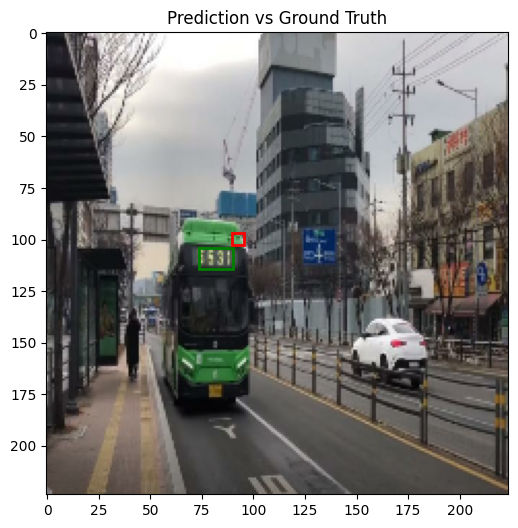

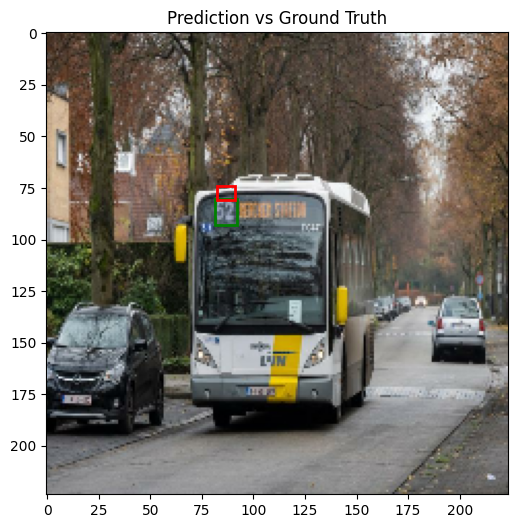

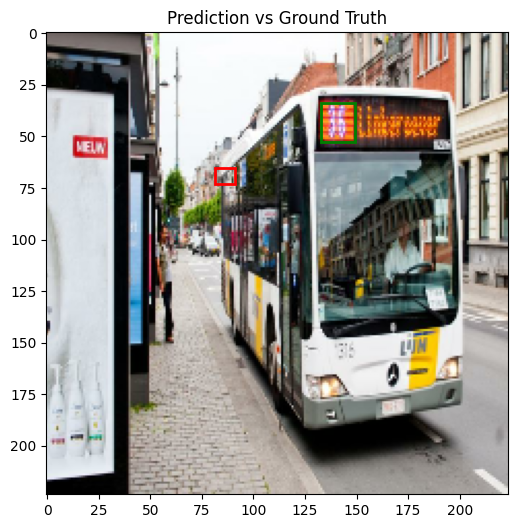

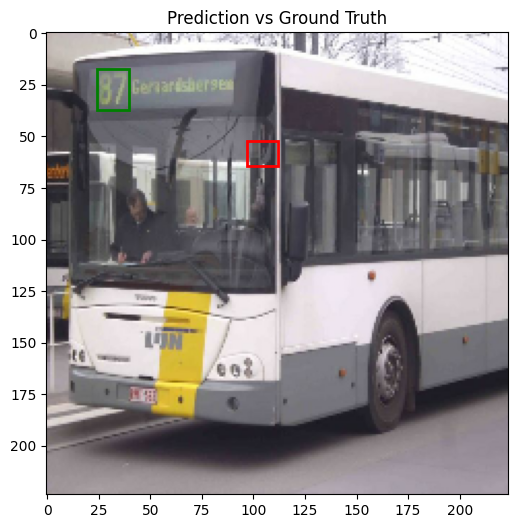

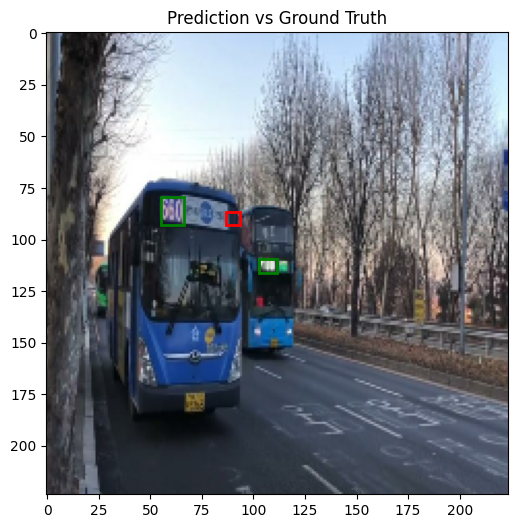

In [33]:
visualize_predictions(model, test_dataset, num_images=5)

In [3]:
# Convert to TFLite
convert_to_tflite(model, "bus_number_detector.tflite")

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node Reshape defined at (most recent call last):
<stack traces unavailable>
Error in user-defined function passed to ParallelMapDatasetV2:2 transformation with iterator: Iterator::Root::Prefetch::PaddedBatchV2::Shuffle::ParallelMapV2: Input to reshape is a tensor with 73602 values, but the requested shape has 150528
	 [[{{node Reshape}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_10628]